In [1]:
!python --version


Python 3.11.9


In [2]:
# Libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
import einops
from torch.nn.functional import interpolate
from glob import glob
import xarray as xr
import numpy as np
import netCDF4

In [3]:
def get_deptht(restart, mask):
    """
    Calculate the depth of each vertical level on grid T in the 3D grid.

    Parameters:
        restart (xarray.Dataset)     : The dataset containing ocean model variables.
        mask (xarray.Dataset) : The dataset containing mask variables.

    Returns:
        deptht (numpy.array) : The depth of each vertical level.
    """
    ssh = restart.sshn.squeeze()
    e3w_0 = mask.e3w_0.squeeze()  # initial z axis cell's thickness on grid W - (t,z,y,x)
    e3t_0 = mask.e3t_0.squeeze()  # initial z axis cell's thickness on grid T - (t,z,y,x)
    tmask = mask.tmask.squeeze()  # grid T continent mask                     - (t,z,y,x)
    ssmask = tmask[:, 0]  # bathymetry                                - (t,y,x)
    bathy = e3t_0.sum(
        dim="depth"
    )  # initial condition depth 0                 - (t,z,y,x)
    depth_0 = e3w_0.copy().squeeze()
    depth_0[:, 0] = 0.5 * e3w_0[:, 0]
    depth_0[:, 1:] = depth_0[:, 0:1].data + e3w_0[:, 1:].cumsum(dim="depth")
    deptht = depth_0 * (1 + ssh / (bathy + 1 - ssmask)) * tmask
    return deptht


def get_density(thetao, so, depth, tmask):
    """
    Compute potential density referenced at the surface and density anomaly.

    Parameters:
        thetao (numpy.array) : Temperature array - (t,z,y,x).
        so (numpy.array)     : Salinity array    - (t,z,y,x).
        depth (numpy.array)  : Depth array       - (t,z,y,x).
        tmask (numpy.array)  : Mask array        - (t,z,y,x).

    Returns:
        tuple: A tuple containing:
            array: Potential density referenced at the surface.
            array: Density anomaly.
    """
    rdeltaS = 32.0
    r1_S0 = 0.875 / 35.16504
    r1_T0 = 1.0 / 40.0
    r1_Z0 = 1.0e-4

    EOS000 = 8.0189615746e02
    EOS100 = 8.6672408165e02
    EOS200 = -1.7864682637e03
    EOS300 = 2.0375295546e03
    EOS400 = -1.2849161071e03
    EOS500 = 4.3227585684e02
    EOS600 = -6.0579916612e01
    EOS010 = 2.6010145068e01
    EOS110 = -6.5281885265e01
    EOS210 = 8.1770425108e01
    EOS310 = -5.6888046321e01
    EOS410 = 1.7681814114e01
    EOS510 = -1.9193502195
    EOS020 = -3.7074170417e01
    EOS120 = 6.1548258127e01
    EOS220 = -6.0362551501e01
    EOS320 = 2.9130021253e01
    EOS420 = -5.4723692739
    EOS030 = 2.1661789529e01
    EOS130 = -3.3449108469e01
    EOS230 = 1.9717078466e01
    EOS330 = -3.1742946532
    EOS040 = -8.3627885467
    EOS140 = 1.1311538584e01
    EOS240 = -5.3563304045
    EOS050 = 5.4048723791e-01
    EOS150 = 4.8169980163e-01
    EOS060 = -1.9083568888e-01
    EOS001 = 1.9681925209e01
    EOS101 = -4.2549998214e01
    EOS201 = 5.0774768218e01
    EOS301 = -3.0938076334e01
    EOS401 = 6.6051753097
    EOS011 = -1.3336301113e01
    EOS111 = -4.4870114575
    EOS211 = 5.0042598061
    EOS311 = -6.5399043664e-01
    EOS021 = 6.7080479603
    EOS121 = 3.5063081279
    EOS221 = -1.8795372996
    EOS031 = -2.4649669534
    EOS131 = -5.5077101279e-01
    EOS041 = 5.5927935970e-01
    EOS002 = 2.0660924175
    EOS102 = -4.9527603989
    EOS202 = 2.5019633244
    EOS012 = 2.0564311499
    EOS112 = -2.1311365518e-01
    EOS022 = -1.2419983026
    EOS003 = -2.3342758797e-02
    EOS103 = -1.8507636718e-02
    EOS013 = 3.7969820455e-01

    zh = depth * r1_Z0  # depth
    zt = thetao * r1_T0  # temperature
    zs = np.sqrt(np.abs(so + rdeltaS) * r1_S0)  # square root salinity
    ztm = tmask.squeeze()

    zn3 = EOS013 * zt + EOS103 * zs + EOS003
    zn2 = (
        (EOS022 * zt + EOS112 * zs + EOS012) * zt + (EOS202 * zs + EOS102) * zs + EOS002
    )
    zn1 = (
        (
            (
                (EOS041 * zt + EOS131 * zs + EOS031) * zt
                + (EOS221 * zs + EOS121) * zs
                + EOS021
            )
            * zt
            + ((EOS311 * zs + EOS211) * zs + EOS111) * zs
            + EOS011
        )
        * zt
        + (((EOS401 * zs + EOS301) * zs + EOS201) * zs + EOS101) * zs
        + EOS001
    )
    zn0 = (
        (
            (
                (
                    (
                        (EOS060 * zt + EOS150 * zs + EOS050) * zt
                        + (EOS240 * zs + EOS140) * zs
                        + EOS040
                    )
                    * zt
                    + ((EOS330 * zs + EOS230) * zs + EOS130) * zs
                    + EOS030
                )
                * zt
                + (((EOS420 * zs + EOS320) * zs + EOS220) * zs + EOS120) * zs
                + EOS020
            )
            * zt
            + ((((EOS510 * zs + EOS410) * zs + EOS310) * zs + EOS210) * zs + EOS110)
            * zs
            + EOS010
        )
        * zt
        + (
            ((((EOS600 * zs + EOS500) * zs + EOS400) * zs + EOS300) * zs + EOS200) * zs
            + EOS100
        )
        * zs
        + EOS000
    )

    zn = ((zn3 * zh + zn2) * zh + zn1) * zh + zn0

    rhop = zn0 * ztm  # potential density referenced at the surface
    rho_insitu = zn * ztm  # density anomaly (masked)
    return rhop, rho_insitu


In [4]:
def check_density(density, epsilon=1e-5) :
    """
    args :
        density (xarray) : DataArray (t, depth, lat, lon) with density value for each point of the grid.
    return :
        (float) proportion of points not respecting density decreasing constraint
    """
    density=density.where(density!=0)
    diff = density  - density.shift(depth=-1)
    return (diff > epsilon).mean().data # Proportion of points not respecting decreasing density





def temperature_500m_30NS_metric(temperature,   file_mask):
    """
        Metric Extraction Function :
        Average Temperature at 500m depth between 30N and 30S.
        Unit : °C    
    
    
        Input : 
           -  thetao    : xarray.DataArray
           -  file_mask : xarray.Dataset
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files 
    
    """
   
    # Taking Temperature At 500m depth and between 30N and 30S.

    t500_30NS=temperature.sel(depth=500,method='nearest').where(abs(temperature.nav_lat)<30,drop=False)

    # Computing Area Weights from Mask over 30N-30S latitude zone and @500m depth
    e1t=file_mask.e1t.squeeze()
    e2t=file_mask.e2t.squeeze()
    tmask=file_mask.tmask.squeeze()
    area_500m_30NS=e1t*e2t*tmask.sel(depth=500,method='nearest').where(abs(temperature.nav_lat)<30,drop=False)

    #Returning Average Temperature at 500m depth as a numpy scalar
    return ((t500_30NS*area_500m_30NS).sum(dim=["nav_lat","nav_lon"])/area_500m_30NS.sum(dim=["nav_lat","nav_lon"]))



def temperature_BWbox_metric(thetao,   file_mask):
    """
        Metric Extraction Function :
        Average Temperature in a U-shaped "Bottom Water" box corresponding to waters below 3000m or beyond 30 degrees of latitude North and South.
        
        ________________________________________________ _Surface
        | . . . . |__________________________| . . . . |_500m
        | . . . . |                          | . . . . |
        | . . . . |        Deep Water        | . . . . |
        | . . . . |__________________________| . . . . |_3000m
        | . . . . . . . . Bottom Water . . . . . . . . |
        |______________________________________________|_Bottom
        S        30S           Eq.          30N        N
        
        Figure : Schematic Representation of the Bottom Water box used in this metric.

        Unit : °C    
    
        Input : 
           -  thetao    : xarray.DataArray
           -  file_mask : xarray.Dataset               
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files 
    
    """

    t_BW=thetao.where(1-(thetao.depth<3000)*(abs(thetao.nav_lat)<30))

    # Computing Area Weights from Mask over Box
    e1t=file_mask.e1t.squeeze()
    e2t=file_mask.e2t.squeeze()
    tmask=file_mask.tmask.squeeze()
    area_BW=e1t*e2t*tmask.where(1-(thetao.depth<3000)*(abs(thetao.nav_lat)<30))

    #Returning Average Temperature on Box
    return ((t_BW*area_BW).sum(dim=["nav_lat","nav_lon","depth"])/area_BW.sum(dim=["nav_lat","nav_lon","depth"]))



def temperature_DWbox_metric(thetao,   file_mask):
    """
        Metric Extraction Function :
        Average Temperature in a "Deep Water" box corresponding to waters between 500m and 3000m depth and 30°N and 30°S.
        
        ________________________________________________ _Surface
        |         |__________________________|         |_500m
        |         | . . . . . . . . . . . . .|         |
        |         | . . . .Deep Water . . . .|         |
        |         |__________________________|         |_3000m
        |                 Bottom Water                 |
        |______________________________________________|_Bottom
        S        30S           Eq.          30N        N
        
        Figure : Schematic Representation of the Deep Water box used in this metric.

        Unit : °C    
    
        Input : 
           -  thetao    : xarray.DataArray
           -  file_mask : xarray.Dataset
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files 
    
    """
    e1t=file_mask.e1t.squeeze()
    e2t=file_mask.e2t.squeeze()
    tmask=file_mask.tmask.squeeze()
    t_DW=thetao.where(abs((thetao.depth-1750)<1250)*(abs(thetao.nav_lat)<30))

    # Computing Area Weights from Mask over Box
    area_DW=e1t*e2t*tmask.where(abs((thetao.depth-1750)<1250)*(abs(thetao.nav_lat)<30))


    #Returning Average Temperature on Box
    return ((t_DW*area_DW).sum(dim=["nav_lat","nav_lon","depth"])/area_DW.sum(dim=["nav_lat","nav_lon","depth"]))




## Version 1 of ACC metric : Computes the flux assuming rigid lid (as if ssh didn’t change)

def ACC_Drake_metric(uo, file_mask):
    """
        Metric Extraction Function :
        Antarctic Circumpolar Current Transport at the DINO equivalent of the Drake Passage (x=0).
        Unit : Sv


        Input :
           -    uo        : xarray.DataArray
           -    file_mask : xarray.Dataset
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files
    
        
    """
                                    
    umask_Drake=file_mask.umask.isel(nav_lon=0).squeeze()
    e3u=file_mask.e3u_0.squeeze()
    e2u=file_mask.e2u.squeeze()

    # Masking the variables onto the Drake Passage
    
    u_masked=uo.isel(nav_lon=0)*umask_Drake
    e3u_masked=e3u.isel(nav_lon=0)*umask_Drake
    e2u_masked=e2u.isel(nav_lon=0)*umask_Drake

    # Multiplying zonal velocity by the sectional areas (e2u*e3u)
    
    ubar=(u_masked*e3u_masked)
    flux=(e2u_masked*ubar).sum(dim=["nav_lat",'depth'])

    #Returning Total Transport across Drake passage as a numpy scalar (unit : Sv)
    return flux/1e6



### Version 2 of ACC metric : Computes the flux assuming varying ssh, thus needing to recompute e3u variable from e3u_0


def ACC_Drake_metric_2(uo, ssh, file_mask):
    """
        Metric Extraction Function :
        Antarctic Circumpolar Current Transport at the DINO equivalent of the Drake Passage (x=0).
        Unit : Sv


        Input :
           -    uo        : xarray.DataArray
           -    ssh       : xarray.DataArray
           -    file_mask : xarray.Dataset
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files
    
        
    """


    e3u_0=file_mask.e3u_0
    e2u=file_mask.e2u
    umask_Drake=file_mask.umask.isel(nav_lon=0)

    # Recomputing e3u, using ssh to refactor the original e3u_0 cell heights)
    
    ssh_u = (ssh + ssh.roll(_nav_lon=-1))/2
    bathy_u   = e3u_0.sum(dim="depth")
    ssumask  = umask_Drake[:,0]
    e3u = e3u_0*(1+ssh_u*ssumask/(bathy_u+1-ssumask))
    
    # Masking the variables onto the Drake Passage
    
    u_masked=uo.isel(nav_lon=0)*umask_Drake
    e3u_masked=e3u.isel(nav_lon=0)*umask_Drake
    e2u_masked=e2u.isel(nav_lon=0)*umask_Drake

    # Multiplying zonal velocity by the sectional areas (e2u*e3u)
    
    ubar=(u_masked*e3u_masked).sum(dim='depth')
    flux=(e2u_masked*ubar).sum()

    #Returning Total Transport across Drake passage as a numpy scalar (unit : Sv)
    return flux.data/1e6



### Intensity of the North-Atlantic SubTropical Gyre (NASTG) computed from the local maximum of the Barotropic Stream Function (BSF)

def NASTG_BSF_max(vo,ssh,file_mask):
    """
        Metric Extraction Function :
        Intensity of the North-Atlantic SubTropical Gyre (NASTG) which contains the Gulf-Stream Current.
        Computed using the Barotropic Stream Function (BSF).
        Unit : Sv
        
 
        Input :
           -    vo        : xarray.DataArray
           -    file_mask : xarray.Dataset
        Output : 
           - np.float32 or np.float64 depending on recording precision of simulation files   
    """

    e3v_0=file_mask.e3v_0.squeeze()
    e1v=file_mask.e1v.squeeze()
    vmask=file_mask.vmask.squeeze()
    # Updating e3v from e3v_0 and SSH
    ssh_v = (ssh + ssh.roll(nav_lat=-1))/2
    bathy_v   = e3v_0.sum(dim="depth")
    ssvmask  = vmask.isel(depth=0)
    e3v = (e3v_0*(1+ssh_v*ssvmask/(bathy_v+1-ssvmask)))

    # Integrating Meridional Transport (e3v*e1v*vo) along depth and X from Western boundary eastward 
    # to get Barotropic Stream Function with the "American continent" as reference point (BSF=0)
    V = (vo * e3v).sum(dim='depth') #  == "Barotropic Velocity" * Bathymetry
    BSF=(V * e1v * ssvmask).cumsum(dim='nav_lon') / 1e6 # Integrating from the West, and converting from m³/s to Sv
    # Selecting 0N-40N window where to search for the maximum, which will correspond to the center of rotation for the gyre
    BSF_NASPG=BSF.where(abs(BSF.nav_lat-20)<20)

    return BSF_NASPG.max(dim=["nav_lat","nav_lon"])


    

In [5]:
# Read restart file
DINO_restart_path = "../nc_files/nc_files/DINO_00576000_restart.nc"
DINO_restart_file=xr.open_dataset(DINO_restart_path).rename({"nav_lev":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_restart_path}")

#Read grid_T file
DINO_1y_grid_T_path = "../nc_files/nc_files/DINO_1y_grid_T.nc"
DINO_1y_grid_T=xr.open_dataset(DINO_1y_grid_T_path,decode_cf=False).rename({"deptht":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1y_grid_T_path}")

#Read grid_U file
DINO_1y_grid_U_path = "../nc_files/nc_files/DINO_1y_grid_U.nc"
DINO_1y_grid_U=xr.open_dataset(DINO_1y_grid_U_path,decode_cf=False).rename({"depthu":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1y_grid_U_path}")

#Read grid_V file
DINO_1y_grid_V_path = "../nc_files/nc_files/DINO_1y_grid_V.nc"
DINO_1y_grid_V=xr.open_dataset(DINO_1y_grid_V_path,decode_cf=False).rename({"depthv":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1y_grid_V_path}")

#Read grid_W file
DINO_1y_grid_W_path = "../nc_files/nc_files/DINO_1y_grid_W.nc"
DINO_1y_grid_W=xr.open_dataset(DINO_1y_grid_W_path,decode_cf=False).rename({"depthw":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1y_grid_W_path}")

#Read grid_T file
DINO_1m_grid_T_path = "../nc_files/nc_files/DINO_1m_grid_T.nc"
DINO_1m_grid_T=xr.open_dataset(DINO_1m_grid_T_path,decode_cf=False).rename({"y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1m_grid_T_path}")

#Read grid_T file
DINO_1m_To_1y_grid_T_path = "../nc_files/nc_files/DINO_1m_To_1y_grid_T.nc"
DINO_1m_To_1y_grid_T=xr.open_dataset(DINO_1m_To_1y_grid_T_path).rename({"y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_1m_To_1y_grid_T_path}")

DINO_1m_To_1y_grid_T["time_counter"] = DINO_1y_grid_T["time_counter"]

# Read the corresponding mesh mask file
DINO_mask_path =  "../nc_files/nc_files/mesh_mask.nc"
DINO_mask_file=xr.open_dataset(DINO_mask_path).rename({"nav_lev":"depth","y":"nav_lat","x":"nav_lon"})
print(f"Successfully loaded dataset from {DINO_mask_path}\n")

Successfully loaded dataset from ../nc_files/nc_files/DINO_00576000_restart.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1y_grid_T.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1y_grid_U.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1y_grid_V.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1y_grid_W.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1m_grid_T.nc
Successfully loaded dataset from ../nc_files/nc_files/DINO_1m_To_1y_grid_T.nc
Successfully loaded dataset from ../nc_files/nc_files/mesh_mask.nc



In [6]:
DINO_1y_grid_T.rhop

<xarray.DataArray 'rhop' (time_counter: 50, depth: 36, nav_lat: 199, nav_lon: 62)> Size: 89MB
[22208400 values with dtype=float32]
Coordinates:
  * depth         (depth) float32 144B 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
  * time_counter  (time_counter) float64 400B -5.905e+10 ... -5.753e+10
Dimensions without coordinates: nav_lat, nav_lon
Attributes:
    standard_name:       sea_water_sigma_theta
    long_name:           potential density (sigma0)
    units:               kg/m3
    online_operation:    average
    interval_operation:  2700 s
    interval_write:      1 yr
    cell_methods:        time: mean (interval: 2700 s)
    _FillValue:          1e+20
    missing_value:       1e+20
    coordinates:         time_centered nav_lat nav_lon

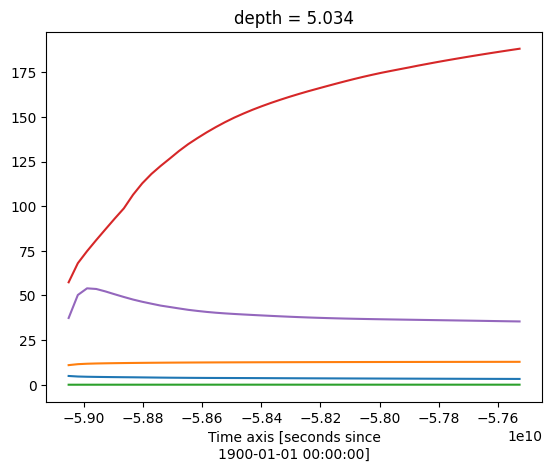

In [24]:
density1 = check_density(DINO_1y_grid_T.rhop)
density2 = check_density(get_density(DINO_1y_grid_T.toce,DINO_1y_grid_T.soce,get_deptht(DINO_restart_file,DINO_mask_file),DINO_mask_file.tmask)[0])

temp500 = temperature_500m_30NS_metric(DINO_1y_grid_T.toce,DINO_mask_file).plot()
tempBW = temperature_BWbox_metric(DINO_1y_grid_T.toce,DINO_mask_file).plot()
tempDW = temperature_DWbox_metric(DINO_1y_grid_U.uoce,DINO_mask_file).plot()
ACC = ACC_Drake_metric(DINO_1y_grid_U.uoce,DINO_mask_file).plot()
NASTG = NASTG_BSF_max(DINO_1y_grid_V.voce,DINO_1m_To_1y_grid_T.ssh,DINO_mask_file).plot()

In [8]:
print(density1)
print(density2)
print(temp500)
print(tempBW)
print(tempDW)
print(ACC)
print(NASTG)

0.00034041173609985413
0.007247167738333243
<xarray.DataArray (time_counter: 50)> Size: 400B
array([4.90448872, 4.601656  , 4.46674859, 4.38521416, 4.31896293,
       4.26012481, 4.20900246, 4.16382454, 4.10598341, 4.04779599,
       3.99047708, 3.93976066, 3.89954792, 3.8636812 , 3.83203385,
       3.80644243, 3.78638544, 3.76980607, 3.75429831, 3.73798509,
       3.71993465, 3.69988917, 3.67838082, 3.6564119 , 3.63507255,
       3.61491564, 3.5959378 , 3.5777776 , 3.56009156, 3.54260229,
       3.52518234, 3.5078034 , 3.49049601, 3.47336707, 3.45639617,
       3.43975718, 3.42361088, 3.4078604 , 3.39251398, 3.37747972,
       3.36282383, 3.34845426, 3.33441966, 3.32070144, 3.30733331,
       3.29429169, 3.28156542, 3.26914145, 3.25701531, 3.24513938])
Coordinates:
    depth         float32 4B 513.9
  * time_counter  (time_counter) float64 400B -5.905e+10 ... -5.753e+10
<xarray.DataArray (time_counter: 50)> Size: 400B
array([10.97669246, 11.51530836, 11.76110375, 11.90633362, 12.00321

In [10]:
# Read prediction file
so_pred_path = "../nc_files/nc_files/pred_so.npy"
so_pred = np.load(so_pred_path)
print(f"Successfully loaded dataset from so_pred")

thetao_pred_path = "../nc_files/nc_files/pred_thetao.npy"
thetao_pred = np.load(thetao_pred_path)
print(f"Successfully loaded dataset from thatao_pred")

zos_pred_path = "../nc_files/nc_files/pred_zos.npy"
zos_pred = np.load(zos_pred_path)
print(f"Successfully loaded dataset from zos_pred")


Successfully loaded dataset from so_pred
Successfully loaded dataset from thatao_pred
Successfully loaded dataset from zos_pred


In [11]:
soce_array = so_pred
soce_array = soce_array[-1,:,:,:][np.newaxis]

toce_array = thetao_pred
toce_array = toce_array[-1,:,:,:][np.newaxis] 

DINO_updated_restart = DINO_restart_file.copy()

DINO_updated_restart.sn[:]=soce_array  #salinity(new)
DINO_updated_restart.tn[:]=toce_array

DINO_updated_restart.sb[:]=soce_array   #salinity(begining)
DINO_updated_restart.tb[:]=toce_array

In [12]:
# DINO_updated_restart.to_netcdf("../nc_files/nc_files/restart_updated.nc")

In [13]:
print("soce_array shape:", soce_array.shape)
print("DINO_updated_restart.sn shape:", DINO_updated_restart.sn.shape)

soce_array shape: (1, 36, 199, 62)
DINO_updated_restart.sn shape: (1, 36, 199, 62)


In [14]:
restart_updated = xr.open_dataset("../nc_files/nc_files/restart_updated.nc")

In [15]:
restart_updated

<xarray.Dataset> Size: 51MB
Dimensions:       (nav_lat: 199, nav_lon: 62, depth: 36, time_counter: 1)
Coordinates:
    nav_lon       (nav_lat, nav_lon) float32 49kB ...
    nav_lat       (nav_lat, nav_lon) float32 49kB ...
  * depth         (depth) float32 144B 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
  * time_counter  (time_counter) float32 4B 5.76e+05
Data variables: (12/29)
    kt            float64 8B ...
    ndastp        float64 8B ...
    adatrj        float64 8B ...
    ntime         float64 8B ...
    utau_b        (time_counter, nav_lat, nav_lon) float64 99kB ...
    vtau_b        (time_counter, nav_lat, nav_lon) float64 99kB ...
    ...            ...
    sshn          (time_counter, nav_lat, nav_lon) float64 99kB ...
    un            (time_counter, depth, nav_lat, nav_lon) float64 4MB ...
    vn            (time_counter, depth, nav_lat, nav_lon) float64 4MB ...
    tn            (time_counter, depth, nav_lat, nav_lon) float64 4MB ...
    sn            (time_counter, depth, nav_lat, nav_lon) float64 4MB ...
    rhop          (time_counter, depth, nav_lat, nav_lon) float64 4MB ...
Attributes:
    file_name:  DINO_00576000_restart.nc
    TimeStamp:  13/11/2024 17:53:42 -0000

In [16]:
# Density present in retart file 
density1 = check_density(restart_updated.rhop[0])
# Density calculated with predicted sn and tn
density2 = check_density(get_density(restart_updated.tn,restart_updated.sn,get_deptht(restart_updated,DINO_mask_file),DINO_mask_file.tmask)[0])

# Temp 
temp500 = temperature_500m_30NS_metric(restart_updated.tn[0],DINO_mask_file)
tempBW = temperature_BWbox_metric(restart_updated.tn[0],DINO_mask_file)
tempDW = temperature_DWbox_metric(restart_updated.un[0],DINO_mask_file)
ACC = ACC_Drake_metric(restart_updated.un[0],DINO_mask_file)
NASTG = NASTG_BSF_max(restart_updated.vn[0],restart_updated.sshn[0],DINO_mask_file)

In [17]:
# Compute outputs
outputs = {
    "Density Constraint1": density1,
    "Density Constraint2":density2 ,
    "Temp 500":temp500 ,
    "Temp BW": tempBW,
    "Temp DW": tempDW,
    "ACC":ACC ,
    "NASTG": NASTG,
}

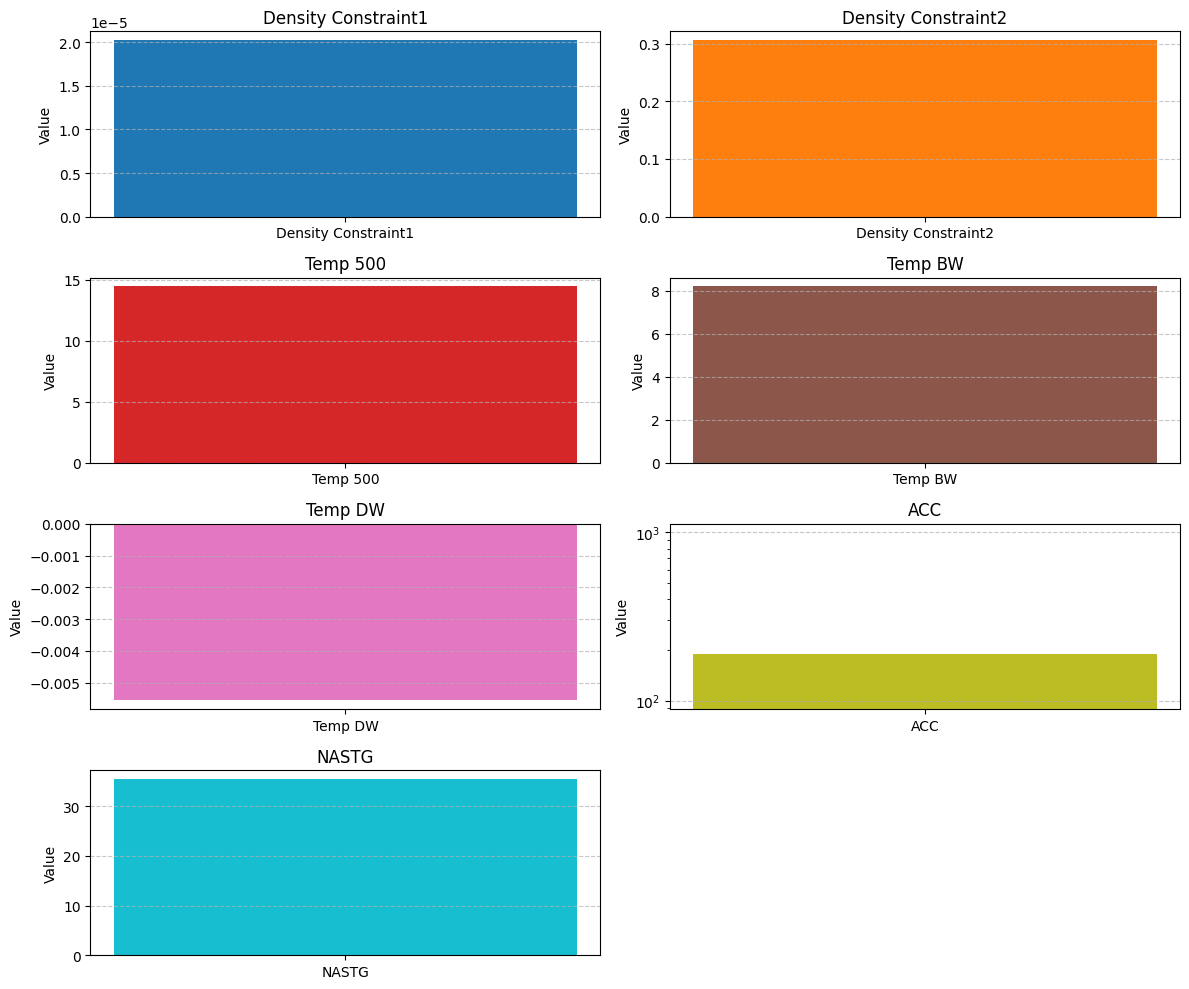

In [ ]:
# Set up subplots (adjusting layout for 7 metrics)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))  # 4 rows, 2 columns
axes = axes.flatten()  

# Generate colors dynamically
colors = plt.cm.tab10(np.linspace(0, 1, len(outputs)))

# Loop through each metric and plot in separate subplot
for idx, (key, value) in enumerate(outputs.items()):
    axes[idx].bar(key, value, color=colors[idx])
    axes[idx].set_title(key)
    axes[idx].set_ylabel("Value")
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust y-scale for better readability
    if value > 100:  # Log scale for large values like ACC
        axes[idx].set_yscale("log")

# Hide any extra unused subplots
for i in range(len(outputs), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [20]:
test_density = get_density(restart_updated.tn,restart_updated.sn,get_deptht(restart_updated,DINO_mask_file),DINO_mask_file.tmask)[1]
test_density.where(test_density!=0)


<xarray.DataArray (time_counter: 1, depth: 36, nav_lat: 199, nav_lon: 62)> Size: 4MB
array([[[[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan, 1028.07811346, 1028.07838407, ...,
          1028.08468779, 1028.08387325,           nan],
         [          nan, 1028.07786642, 1028.07802212, ...,
          1028.08513484, 1028.08391499,           nan],
         ...,
         [          nan, 1028.41427607, 1028.41262747, ...,
          1028.43132532, 1028.39504783,           nan],
         [          nan, 1028.41580503, 1028.41740187, ...,
          1028.42782874, 1028.40923904,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan, 1028.07941668, 1028.07968876, ...,
          1028.08601993, 1028.08519982,           nan],
         [          nan, 1028.07916823, 1028.07932438, ...,
          1028.08646902, 1028.08524128,           nan],
...
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]],

        [[          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan],
         [          nan,           nan,           nan, ...,
                    nan,           nan,           nan]]]])
Coordinates:
    nav_lon       (nav_lat, nav_lon) float32 49kB -0.5 0.5 1.5 ... 59.5 60.5
    nav_lat       (nav_lat, nav_lon) float32 49kB -69.85 -69.85 ... 69.85 69.85
  * depth         (depth) float32 144B 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
  * time_counter  (time_counter) float32 4B 5.76e+05

In [21]:
restart_updated.rhop[0]

<xarray.DataArray 'rhop' (depth: 36, nav_lat: 199, nav_lon: 62)> Size: 4MB
[444168 values with dtype=float64]
Coordinates:
    nav_lon       (nav_lat, nav_lon) float32 49kB ...
    nav_lat       (nav_lat, nav_lon) float32 49kB ...
  * depth         (depth) float32 144B 5.034 15.32 25.96 ... 3.757e+03 4.253e+03
    time_counter  float32 4B 5.76e+05